## Imports

In [1]:
import sys
import torch
import random
import numpy as np
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt

sys.path.append("../")
sys.path.append("../..")
####### Dataset ############
from evaluation import main
from data_processor import DataProcessor
######## Search space #########
from search_space.RegNet import RegNet
from search_space.utils import create_widths_plot, scatter_results, get_generation_dfs
######## Training ###############
from trainer import Trainer, TrainerDistillation
from utils.train_cfg import get_cfg, show_cfg
###################################################
random_seed = 1
random.seed(random_seed)
# Set seed for NumPy
np.random.seed(random_seed)
# Set seed for PyTorch
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
# Additional steps if using CuDNN (optional, for GPU acceleration)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
from coolname import generate_slug
from sklearn.metrics import accuracy_score

/home/hpc/iwb3/iwb3021h/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset

[RandomCrop(size=(24, 24), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant), RandomHorizontalFlip(p=0.5)]
[Normalize(mean=[tensor(0.0417)], std=[tensor(0.1998)], inplace=False)]
[Normalize(mean=[tensor(0.0417)], std=[tensor(0.1998)], inplace=False)]


{'num_classes': 10,
 'codename': 'LaMelo',
 'input_shape': [50000, 1, 24, 24],
 'benchmark': 85.2,
 'rand_augment': False}

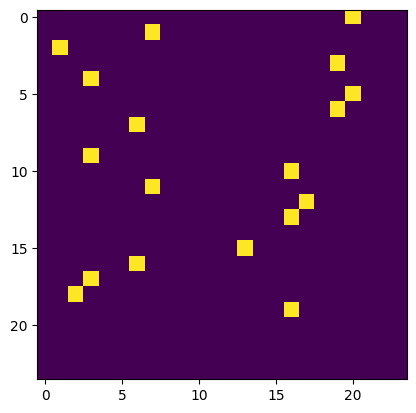

In [2]:
#Dataset must be in the folder datasets
# From https://github.com/Towers-D/NAS-Unseen-Datasets
Dataset="Language"
(train_x, train_y), (valid_x, valid_y), (test_x), metadata = main.load_datasets(Dataset, truncate=False)
#test_y = np.load(os.path.join('../datasets/'+Dataset,'test_y.npy'))
metadata["rand_augment"]=False
data_processor = DataProcessor(train_x, train_y, valid_x, valid_y, test_x, metadata)
train_loader, valid_loader, test_loader = data_processor.process()


img=next(iter(train_loader))[0][0]
img=img.numpy().transpose(1, 2, 0)
plt.imshow(img)

metadata

## Search space

In [3]:
#metadata={"num_classes": 4, "input_shape": [49260, 3, 64, 64], "codename": "Caitie", "benchmark":47.008}
regnet_space=RegNet(metadata,
                    W0=[16, 64, 8],
                    WA=[8, 48, 8],
                    WM=[2.05,2.9,0.05],
                    D=[8,22,1], 
                    G=[8,16,8], 
                    base_config="../configs/search_space/config.yaml")
print(regnet_space.cfg)

BN:
  EPS: 1e-05
  MOM: 0.1
  ZERO_INIT_FINAL_GAMMA: False
DESC: 
LN:
  EPS: 1e-05
MODEL:
  ACTIVATION_FUN: relu
  ACTIVATION_INPLACE: True
  NUM_CLASSES: 10
  SCALING_FACTOR: 1.0
  SCALING_TYPE: 
  TYPE: regnet
REGNET:
  BLOCK_TYPE: res_bottleneck_block
  BOT_MUL: 1.0
  DEPTH: 20
  DOWNSAMPLE: avg
  DROPOUT: 0.1
  DROP_RATE: 0.01
  GROUP_W: 8
  HEAD_W: 128
  INPUT_CHANNELS: 1
  SE_ON: True
  SE_R: 0.25
  STEM_TYPE: res_stem_cifar
  STEM_W: 24
  STRIDE: 2
  W0: 232
  WA: 115.89
  WM: 2.53


# Create model

In [4]:

# Folder to save the model
test_folder="test_diswot"
# Config update is used to modify other parameter from the config
#config_updates=["REGNET.SE_ON", False]
#config_updates=["REGNET.DROP_RATE",0.05, "REGNET.DROPOUT",0.1]

config_updates=None
WA,W0,WM,DEPTH, Group_w=[48,56,2.4,12,8]
# if name is none, it creates a random name
model_name=generate_slug(2).replace("-", "_")
model, info=regnet_space.create_model(params=[float(WA),int(W0),float(WM),int(DEPTH), Group_w], save_folder=test_folder, name=model_name, gen=None, config_updates=config_updates)


Created model:  daring_crayfish


## DisWOT distillation

In [5]:
test_folder="tests_LaMelo_08_06_2024_20_42"
gen=1
model_name="amaranth_python"
#regnet_space=nas.regnet_space

config_updates=None
config_updates=("REGNET.HEAD_W",128)
# If already trained, add weights_file.
#weights_file=f"{test_folder}/Generation_{gen}/{model_name}/student_best"
#weights_file=f"{test_folder}/finetuning/{model_name}_sgd_50_128_swa/student_best"
weights_file=None
student,info=regnet_space.load_model(config_file=f"{test_folder}/Generation_{gen}/{model_name}/config.yaml",
                                   weights_file=weights_file, config_updates=config_updates)

Loading model: tests_LaMelo_08_06_2024_20_42/Generation_1/amaranth_python/config.yaml


In [6]:
# If already trained, add weights_file.
gen=1
model_name="demonic_pheasant"

weights_file=f"{test_folder}/finetuning/{model_name}_sgd_50_128_swa/student_best"
#weights_file=f"{test_folder}/finetuning/{model_name}_sgd_50_128_swa/student_best"
#weights_file=None

teacher,info=regnet_space.load_model(config_file=f"{test_folder}/Generation_{gen}/{model_name}/config.yaml",
                                   weights_file=weights_file, config_updates=config_updates)

Loading model: tests_LaMelo_08_06_2024_20_42/Generation_1/demonic_pheasant/config.yaml


In [ ]:
test_folder="tests_LaMelo_08_06_2024_20_42"
import gc
gen=1
subjects=os.listdir(test_folder+f"/Generation_{gen}")
subjects=[subject for subject in subjects if os.path.isdir(f"{test_folder}/Generation_{gen}/{subject}")]
sem_metrics={}
rel_metrics={}
diswot_sims={}           
for model_name in subjects[:]:
    sem_metrics[model_name]=0
    rel_metrics[model_name]=0
    diswot_sims[model_name]=0
    #model_name="amaranth_python"
    #regnet_space=nas.regnet_space

    config_updates=None
    weights_file=None
    student,info=regnet_space.load_model(config_file=f"{test_folder}/Generation_{gen}/{model_name}/config.yaml",
                                       weights_file=weights_file, config_updates=config_updates)

    gen=1
    model_name_t="demonic_pheasant"
    weights_file=f"{test_folder}/finetuning/{model_name_t}_sgd_50_128_swa/student_best"   
    teacher,info=regnet_space.load_model(config_file=f"{test_folder}/Generation_{gen}/{model_name_t}/config.yaml",
                                   weights_file=weights_file, config_updates=config_updates)
    #batch_data=next(iter(train_loader))
    teacher.eval()
    student.eval()
    for idx, batch_data in enumerate(train_loader):
        sem_metric=semantic_similarity_metric(teacher, student, batch_data)
        #rel_metric=relation_similarity_metric(teacher, student, batch_data)
        #print(rel_metric)
        #diswot_sim=sem_metric+rel_metric
        sem_metrics[model_name]+=sem_metric
        #rel_metrics[model_name]+=rel_metric
        #diswot_sims[model_name]+=diswot_sim
        torch.cuda.empty_cache()
        gc.collect()
    print(sem_metrics[model_name])
    print(rel_metrics[model_name])
    print(diswot_sims[model_name])

Loading model: tests_LaMelo_08_06_2024_20_42/Generation_1/resourceful_okapi/config.yaml
Loading model: tests_LaMelo_08_06_2024_20_42/Generation_1/demonic_pheasant/config.yaml
tensor(-1309.2478, device='cuda:0')
0
0
Loading model: tests_LaMelo_08_06_2024_20_42/Generation_1/cherry_nightingale/config.yaml
Loading model: tests_LaMelo_08_06_2024_20_42/Generation_1/demonic_pheasant/config.yaml
tensor(-1268.2102, device='cuda:0')
0
0
Loading model: tests_LaMelo_08_06_2024_20_42/Generation_1/spectral_dolphin/config.yaml
Loading model: tests_LaMelo_08_06_2024_20_42/Generation_1/demonic_pheasant/config.yaml


In [12]:
import pandas as pd
df_rank=pd.read_csv("tests_LaMelo_08_06_2024_20_42/Generation_1/results.csv", index_col=0)

In [34]:
df_rank=df_rank.sort_values("best_acc", ascending=False)[["name", "best_acc"]]

In [39]:
sim_df=pd.DataFrame([rel_metrics]).T.reset_index().rename(columns={0:"sim_score", "index":"name"}).sort_values("sim_score", ascending=False)

In [41]:
df_rank=df_rank.merge(sim_df, on="name")

In [42]:
np.corrcoef(df_rank.best_acc.values, df_rank.sim_score.values)

array([[ 1.        , -0.14497554],
       [-0.14497554,  1.        ]])

In [25]:
for ind in rel_metrics.keys():
    rel_metrics[ind]=rel_metrics[ind].item()

In [6]:
import torch
import torch.nn as nn 
import torch.nn.functional as F


In [5]:
def get_stage_names(model):
    stages = []
    for name, module in model.named_children():
        # You can customize this check based on how stages/blocks are defined in your model
        if isinstance(module, (nn.Sequential, nn.ModuleList)) or len(list(module.children())) > 0:
            stages.append(name)
    return stages
def get_features(model, input_data, target_layer_name):
    features = {}

    def hook(module, input, output):
        features[target_layer_name] = output.detach()  # Detach to avoid memory issues

    layer = dict([*model.named_modules()])[target_layer_name]
    handle = layer.register_forward_hook(hook)

    with torch.no_grad():  # Use no_grad to save memory
        model(input_data.to(device))  # Perform a forward pass to trigger the hook
    
    handle.remove()  # Remove the hook
    return features[target_layer_name].cpu()

def relation_similarity_metric(teacher, student, batch_data):
    image, label = batch_data
    # Forward pass
    #t_feats = teacher.forward_features(image)
    #s_feats = student.forward_features(image)

    t_feat = get_features(teacher, image, get_stage_names(teacher)[-1])
    s_feat = get_features(student, image, get_stage_names(student)[-1])

    # Get activation before average pooling
    #t_feat = t_feats[-2]
    #s_feat = s_feats[-2]
    # Compute batch similarity
    return -1 * batch_similarity(t_feat, s_feat)

def batch_similarity(f_t, f_s):
    # Reshape
    bsz=f_s.shape[0]
    f_s = f_s.view(f_s.shape[0], -1)
    f_t = f_t.view(f_t.shape[0], -1)
    # Get batch-wise similarity matrix
    G_s = torch.mm(f_s, torch.t(f_s))
    G_s = F.normalize(G_s)
    G_t = torch.mm(f_t, torch.t(f_t))
    G_t = F.normalize(G_t)
    # Produce L_2 distance
    G_diff = G_t - G_s
    return (G_diff * G_diff).view(-1, 1).sum() / (bsz * bsz)
 
def semantic_similarity_metric(teacher, student, batch_data):
    criterion = nn.CrossEntropyLoss() 
    image, label = batch_data 
    # Forward once.
    t_logits = teacher(image.to(device))
    s_logits = student(image.to(device))
    # Backward once.
    criterion(t_logits.to(device), label.to(device)).backward()
    criterion(s_logits.to(device), label.to(device)).backward()
    # Grad-cam of fc layer.
    t_grad_cam = teacher.head.fc.weight.grad
    s_grad_cam = student.head.fc.weight.grad
    # Compute channel-wise similarity
    return -1 * channel_similarity(t_grad_cam, s_grad_cam)

def channel_similarity(f_t, f_s):
    bsz, ch = f_s.shape[0], f_s.shape[1]
    # Reshape
    f_s = f_s.view(bsz, ch, -1)
    f_t = f_t.view(bsz, ch, -1)
    # Get channel-wise similarity matrix
    emd_s = torch.bmm(f_s, f_s.permute(0, 2, 1))
    emd_s = F.normalize(emd_s, dim=2)
    emd_t = torch.bmm(f_t, f_t.permute(0, 2, 1))
    emd_t = F.normalize(emd_t, dim=2)
    # Produce L_2 distance
    G_diff = emd_s - emd_t
    return (G_diff * G_diff).view(bsz, -1).sum() / (ch * bsz)

In [131]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.feature_maps = None
        self.hook_handles = []

        # Register forward hook
        self.hook_handles.append(self.target_layer.register_forward_hook(self.forward_hook))
        # Register backward hook
        self.hook_handles.append(self.target_layer.register_backward_hook(self.backward_hook))

    def forward_hook(self, module, input, output):
        self.feature_maps = output

    def backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def __call__(self, input_tensor, class_idx):
        # Forward pass
        output = self.model(input_tensor)
        # Zero gradients
        self.model.zero_grad()
        # Backward pass with respect to the target class
        one_hot_output = torch.zeros_like(output)
        one_hot_output[0, class_idx] = 1
        output.backward(gradient=one_hot_output, retain_graph=True)

        # Compute Grad-CAM
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        grad_cam = torch.sum(weights * self.feature_maps, dim=1).squeeze()
        grad_cam = F.relu(grad_cam)
        grad_cam = grad_cam / torch.max(grad_cam)
        grad_cam = grad_cam.detach().cpu().numpy()

        return grad_cam

    def clear_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

In [115]:
grad_func_stu=GradCAM(student, student.s3)
cam_stu=grad_func_stu(batch_data[0].to(device), 1)

grad_func_tea=GradCAM(teacher, teacher.s2)
cam_tea=grad_func_tea(batch_data[0].to(device), 1)

In [9]:
batch_data=next(iter(train_loader))
sem_metric=semantic_similarity_metric(teacher, student, batch_data)
rel_metric=relation_similarity_metric(teacher, student, batch_data)
diswot_sim=sem_metric+rel_metric

last stage teacher: head
last stage student: head
torch.Size([64, 10])
torch.Size([64, 10])


In [10]:
diswot_sim

tensor(-1.4284, device='cuda:0', grad_fn=<AddBackward0>)

In [75]:
relation_similarity_metric(teacher, student, batch_data)

last stage teacher: head
last stage student: head
torch.Size([64, 10])
torch.Size([64, 10])


tensor(-0.0231, device='cuda:0', grad_fn=<MulBackward0>)

In [39]:
student.head.fc.weight.grad.shape

torch.Size([10, 904])

In [35]:
teacher.head.fc.weight.grad.shape

torch.Size([10, 336])

In [103]:
summary(student, (1, 24,24))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 24, 24]             216
       BatchNorm2d-2           [-1, 24, 24, 24]              48
              ReLU-3           [-1, 24, 24, 24]               0
      ResStemCifar-4           [-1, 24, 24, 24]               0
            Conv2d-5          [-1, 120, 24, 24]           2,880
       BatchNorm2d-6          [-1, 120, 24, 24]             240
              ReLU-7          [-1, 120, 24, 24]               0
            Conv2d-8          [-1, 120, 12, 12]           8,640
       BatchNorm2d-9          [-1, 120, 12, 12]             240
             ReLU-10          [-1, 120, 12, 12]               0
AdaptiveAvgPool2d-11            [-1, 120, 1, 1]               0
           Conv2d-12              [-1, 6, 1, 1]             726
             ReLU-13              [-1, 6, 1, 1]               0
           Conv2d-14            [-1, 12

In [102]:
from torchsummary import summary
summary(teacher, (1, 24,24))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 24, 24]             216
       BatchNorm2d-2           [-1, 24, 24, 24]              48
              ReLU-3           [-1, 24, 24, 24]               0
      ResStemCifar-4           [-1, 24, 24, 24]               0
            Conv2d-5          [-1, 120, 24, 24]           2,880
       BatchNorm2d-6          [-1, 120, 24, 24]             240
              ReLU-7          [-1, 120, 24, 24]               0
            Conv2d-8          [-1, 120, 12, 12]           8,640
       BatchNorm2d-9          [-1, 120, 12, 12]             240
             ReLU-10          [-1, 120, 12, 12]               0
AdaptiveAvgPool2d-11            [-1, 120, 1, 1]               0
           Conv2d-12              [-1, 6, 1, 1]             726
             ReLU-13              [-1, 6, 1, 1]               0
           Conv2d-14            [-1, 12

## Load model

In [5]:
model_name

'daring_crayfish'

In [6]:
# If already trained, add weights_file.
#weights_file=f"{test_folder}/{model_name}/student_best"

#model,info=regnet_space.load_model(config_file=f"{test_folder}/{model_name}/config.yaml",
#                                   weights_file=None)


In [7]:
from torchsummary import summary
summary(model, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 28, 64, 64]             756
       BatchNorm2d-2           [-1, 28, 64, 64]              56
              ReLU-3           [-1, 28, 64, 64]               0
      ResStemCifar-4           [-1, 28, 64, 64]               0
            Conv2d-5           [-1, 56, 64, 64]           1,568
       BatchNorm2d-6           [-1, 56, 64, 64]             112
              ReLU-7           [-1, 56, 64, 64]               0
            Conv2d-8           [-1, 56, 32, 32]           4,032
       BatchNorm2d-9           [-1, 56, 32, 32]             112
             ReLU-10           [-1, 56, 32, 32]               0
AdaptiveAvgPool2d-11             [-1, 56, 1, 1]               0
           Conv2d-12              [-1, 7, 1, 1]             399
             ReLU-13              [-1, 7, 1, 1]               0
           Conv2d-14             [-1, 5

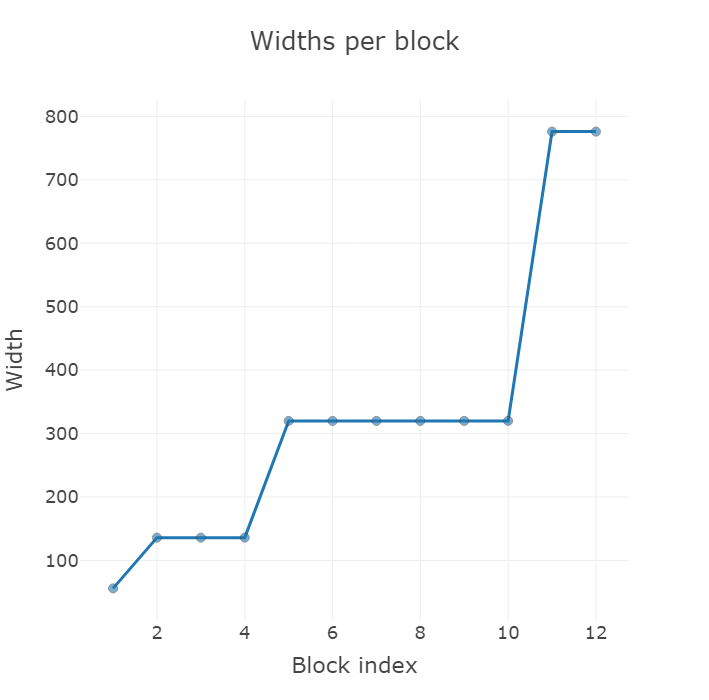

In [12]:
create_widths_plot({model_name:info})

## Train model

In [15]:
# Show train config file
metadata["train_config_path"]="../configs/train/vanilla_generation_lion.yaml"
train_cfg=get_cfg()
train_cfg.merge_from_file(metadata["train_config_path"])
show_cfg(train_cfg)

[INFO] CONFIG:
DATASET:
  CLASSES: 0
  INPUT_SHAPE: []
  NUM_WORKERS: 2
  TEST:
    BATCH_SIZE: 64
  TYPE: ''
DISTILLER:
  STUDENT: null
  TEACHER: NONE
  TYPE: NONE
EXPERIMENT:
  LOGIT_STAND: false
  NAME: ''
  PROJECT: ''
SOLVER:
  BATCH_SIZE: 128
  EPOCHS: 3
  LABEL_SMOOTHING: 0.1
  LR: 0.0005
  LR_SCHEDULER: one_cycle
  MOMENTUM: 0.9
  TOPK: 2
  TRAINER: base
  TYPE: Lion
  WARMUP: false
  WEIGHT_DECAY: 0.01



In [17]:
clear_output(wait=True)
metadata["experiment_name"]=f"{test_folder}/{model_name}_base"
trainer=TrainerDistillation(model, device, train_loader, valid_loader, metadata) 
#trainer.train()

0.0005
703
3


In [18]:
trainer.train()

[TRAIN] Epoch:1| Time(data):0.000| Time(train):0.081| Loss:2.9360| Top-1:7.921| Top-2:15.009: 100%|██████████| 703/703 [01:15<00:00,  9.28it/s]


2.0002967962043285e-05


[EVAL] Top-1:13.060| Top-2:23.167: 100%|██████████| 235/235 [00:07<00:00, 33.43it/s]
[TRAIN] Epoch:2| Time(data):0.000| Time(train):0.081| Loss:2.6644| Top-1:15.347| Top-2:26.405: 100%|██████████| 703/703 [01:15<00:00,  9.28it/s]


2.001187177476637e-05


[EVAL] Top-1:19.407| Top-2:31.927: 100%|██████████| 235/235 [00:07<00:00, 33.30it/s]
[TRAIN] Epoch:3| Time(data):0.000| Time(train):0.081| Loss:2.5024| Top-1:20.910| Top-2:32.906: 100%|██████████| 703/703 [01:15<00:00,  9.28it/s]


2.0026711217951206e-05


[EVAL] Top-1:24.713| Top-2:37.727: 100%|██████████| 235/235 [00:07<00:00, 33.13it/s]


[EVAL] Best accuracy:24.713333129882812


RegNet(
  (stem): ResStemCifar(
    (conv): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (af): ReLU(inplace=True)
  )
  (s1): AnyStage(
    (b1): ResBottleneckBlock(
      (f): BottleneckTransform(
        (a): Conv2d(28, 56, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (a_bn): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (a_af): ReLU(inplace=True)
        (b): Conv2d(56, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=7, bias=False)
        (b_bn): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (b_af): ReLU(inplace=True)
        (se): SE(
          (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
          (f_ex): Sequential(
            (0): Conv2d(56, 7, kernel_size=(1, 1), stride=(1, 1))
            (1): ReLU(inplace=True)
            (2): Conv2d(7, 5

In [ ]:
len(train_loader)

In [1]:
#%pip install --proxy http://proxy:80 triton -U --pre


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 5.7 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
!python mp.py

[RandomCrop(size=(28, 28), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant), RandomHorizontalFlip(p=0.5)]
[Normalize(mean=[tensor(0.0053), tensor(0.0066), tensor(0.0077)], std=[tensor(1.0065), tensor(1.0080), tensor(1.0092)], inplace=False)]
[Normalize(mean=[tensor(0.0053), tensor(0.0066), tensor(0.0077)], std=[tensor(1.0065), tensor(1.0080), tensor(1.0092)], inplace=False)]
Created model:  daring_crayfish
res_bottleneck_block
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.01, 'dropout_rate': 0.1}
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.01, 'dropout_rate': 0.1}
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.01, 'dropout_rate': 0.1}
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.01, 'dropout_rate': 0.1}
{'stem_type': 'res_stem_cifar', 'stem_w': 28, 'input_channels': 3, 'block_type': 'res_bottleneck_blo

In [2]:
#!rm -rf test_multiprocessing

In [23]:
predictions = trainer.predict(test_loader)
test_score = 100*accuracy_score(test_y, predictions)
print(test_score)

## LR test

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt

def train_one_epoch(model, dataloader, criterion, optimizer, scheduler, batches_per_lr):
    model.train()
    losses = []
    lrs = []

    num_batches=len(dataloader)
    batch_count=0
    
    running_loss=0.0
    
    for i, (inputs, targets) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, targets.to(device))
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
        batch_count+=1
        # Record the learning rate and loss
        if batch_count==batches_per_lr or i==num_batches-1:
            lr = scheduler.get_last_lr()[0]
            lrs.append(lr)
            losses.append(running_loss/batch_count)

            # Step the scheduler
            scheduler.step()
            running_loss=0.0
            batch_count=0
    return losses, lrs
from lion_pytorch import Lion
def lr_range_test(model, dataloader, start_lr, end_lr, num_iter, batches_per_lr):
    #optimizer = optim.SGD(model.parameters(), lr=start_lr)
    optimizer= Lion(model.parameters(), lr=start_lr, betas=(0.9, 0.99), weight_decay=1e-2)
    #criterion = nn.MSELoss()
    criterion = nn.CrossEntropyLoss()

    # Lambda function to increase the learning rate exponentially
    lr_lambda = lambda x: (end_lr / start_lr) ** (x / num_iter)
    scheduler = LambdaLR(optimizer, lr_lambda)

    losses, lrs = train_one_epoch(model, dataloader, criterion, optimizer, scheduler, batches_per_lr)

    return losses, lrs

# Initialize the model
#model = models[list(models.keys())[10]].to(device)

# Perform the learning rate range test
start_lr = 1e-6
end_lr = 0.1
batches_per_lr=4
num_iter = len(train_loader)/batches_per_lr  # Number of iterations for one epoch

losses, lrs = lr_range_test(model, train_loader, start_lr, end_lr, num_iter, batches_per_lr)



In [19]:
min_index = losses.index(min(losses))
best_lr = lrs[min_index]
print(best_lr)

0.0007471360903988472


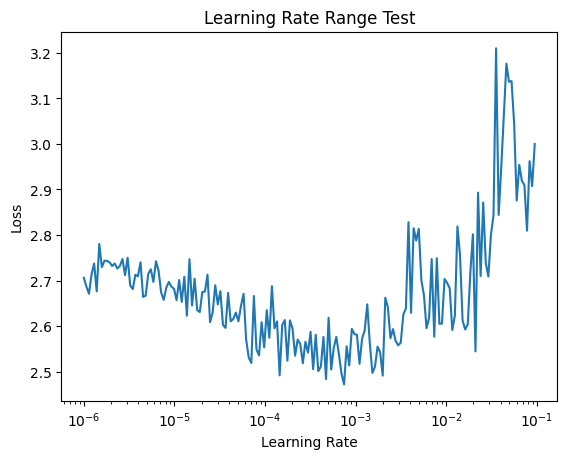

In [14]:
# Plot the results
plt.plot(lrs[:], losses[:])
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate Range Test')
plt.show()